<h1 id="title">Sampling at 10 x Minority Class Size for Predicting Motor Vehicle Accidents in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f0bf49c0040>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.87157087691594 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.221266153967008 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.486548725981265 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.19319270097185 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,2,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,2,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,2,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,2,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,2,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.56751755194273 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.618006904958747 seconds.


<h2 id='sample_size_class_3'>Balance the Dataset by Sampling all Classes Equally<\h2>

In [34]:
# This sampling parameter provides conventient control for the oversampling of the minority classes
# and, consequently, for the undersampling of the majority classes.
sampling_parameter = 10 * class_3_size

In [35]:
# Set the size of sample to take from each class of accident severity.
# To balance the dataset, ensure that all samples are of the same size.
sample_size_class_1 = np.int(sampling_parameter)
sample_size_class_2 = np.int(sampling_parameter)
sample_size_class_2b = np.int(sampling_parameter)
sample_size_class_3 = np.int(sampling_parameter)

In [36]:
# Sample all classes equally, with the number of samples equal to the size of class '3'.
# Replacement flag is boolean with value set as follows:
# If class_size > sample_size, then parameter replace is passed the value True.
# Otherwise, parameter replace is passed the value False.
replaceFlag = bool(class_1_size < sample_size_class_1)
print('bool(class_1_size < sample_size_class_1) = %s' % bool(class_1_size < sample_size_class_1))
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1,replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2_size < sample_size_class_2)
print('bool(class_2_size < sample_size_class_2) = %s' % bool(class_2_size < sample_size_class_2))
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2b_size < sample_size_class_2b)
print('bool(class_2b_size < sample_size_class_2b) = %s' % bool(class_2b_size < sample_size_class_2b))
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_3_size < sample_size_class_3)
print('bool(class_3_size < sample_size_class_3) = %s' % bool(class_3_size < sample_size_class_3))
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=replaceFlag, axis='index', random_state=seed)

bool(class_1_size < sample_size_class_1) = False
bool(class_2_size < sample_size_class_2) = False
bool(class_2b_size < sample_size_class_2b) = True
bool(class_3_size < sample_size_class_3) = True


In [37]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [38]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced = shuffle(df_balanced_not_shuffled, random_state=seed)

In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     3280
2b    3280
2     3280
1     3280
Name: SEVERITYCODE, Length: 4, dtype: int64


In [40]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [41]:
X = df_balanced.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13120 entries, 180254 to 113078
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  13120 non-null  category
 1   PERSONCOUNT    13120 non-null  int64   
 2   PEDCOUNT       13120 non-null  int64   
 3   PEDCYLCOUNT    13120 non-null  int64   
 4   VEHCOUNT       13120 non-null  int64   
 5   WEATHER        13120 non-null  category
 6   ROADCOND       13120 non-null  category
 7   LIGHTCOND      13120 non-null  category
dtypes: category(4), int64(4)
memory usage: 565.3 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [43]:
y = df_balanced["SEVERITYCODE"].to_numpy()

In [44]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.794461808982305 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [45]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')
#encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.09757844905834645 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7'
 'x1_8' 'x1_9' 'x1_10' 'x1_11' 'x1_12' 'x1_13' 'x1_14' 'x1_15' 'x1_19'
 'x1_22' 'x1_23' 'x1_28' 'x1_31' 'x1_93' 'x2_0' 'x2_1' 'x2_2' 'x2_3'
 'x2_4' 'x2_5' 'x3_0' 'x3_1' 'x3_2' 'x4_0' 'x4_1' 'x4_2' 'x4_3' 'x4_4'
 'x4_5' 'x4_6' 'x4_7' 'x4_8' 'x4_13' 'x4_14' 'x4_15'
 'x5_Blowing Sand/Dirt' 'x5_Clear' 'x5_Fog/Smog/Smoke' 'x5_Other'
 'x5_Overcast' 'x5_Partly Cloudy' 'x5_Raining' 'x5_Severe Crosswind'
 'x5_Sleet/Hail/Freezing Rain' 'x5_Snowing' 'x6_Dry' 'x6_Ice' 'x6_Oil'
 'x6_Other' 'x6_Sand/Mud/Dirt' 'x6_Snow/Slush' 'x6_Standing Water'
 'x6_Wet' 'x7_Dark - No Street Lights' 'x7_Dark - Street Lights Off'
 'x7_Dark - Street Lights On' 'x7_Dawn' 'x7_Daylight' 'x7_Dusk' 'x7_Other']


In [46]:
type(X)

scipy.sparse.csr.csr_matrix

In [47]:
X.shape

(13120, 78)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.294481729972176 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 69.352498 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 91.80952652194537 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 8.539095 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 100.52473853901029 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10
# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)
# Only us an odd number of neighbors to avoid ties.
#grid_parameters = {'n_neighbors': range(3, maximum_number_of_neighbors, 2),\
#                   'weights': ['distance', 'uniform']} 
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_macro']
grid_search_cv = GridSearchCV(k_neighbors_clf, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_macro', cv=number_of_folds, verbose=100, pre_dispatch=2**8, error_score='raise',\
                              return_train_score=False)
grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=256, refit='recall_macro', scoring=['recall_macro'],
             verbose=100)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 3772.694754 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=153, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=153, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 153
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 82.555788 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 3956.253910515923 seconds.


## Validation of the Models

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [60]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
print("Transforming full data set's feature set using OneHotEncoder...")
X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")

Transforming full data set's feature set using OneHotEncoder...
Completed in 0.8531516810180619 seconds.


In [61]:
y = df_categorical['SEVERITYCODE'].to_numpy()

In [62]:
X.shape

(171872, 78)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sampling_parameter, random_state=seed, shuffle=True)

In [64]:
X_test.shape

(3280, 78)

In [65]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

fit_time: mean = 12.196703, std = 0.864835
fit_time :[12.22827315 13.79508567 12.58908844 13.21224928 11.44245172 10.61112547
 11.46532631 12.24053645 12.43479967 11.94809842]

score_time: mean = 0.261819, std = 0.066097
score_time :[0.29632306 0.2280829  0.19929981 0.39675832 0.20093226 0.25678968
 0.28765869 0.22832847 0.34483266 0.17918372]

test_f1_macro: mean = 0.483945, std = 0.008822
test_f1_macro :[0.49015665 0.46782326 0.48665365 0.47558682 0.49619875 0.49330027
 0.49239334 0.481985   0.47531427 0.48004008]

test_f1_weighted: mean = 0.483945, std = 0.008822
test_f1_weighted :[0.49015665 0.46782326 0.48665365 0.47558682 0.49619875 0.49330027
 0.49239334 0.481985   0.47531427 0.48004008]

test_neg_log_loss: mean = -1.110834, std = 0.016520
test_neg_log_loss :[-1.08583734 -1.13840317 -1.10829435 -1.1192464  -1.09198365 -1.091507
 -1.12384253 -1.10290328 -1.1221924  -1.12413293]

test_precision_macro: mean = 0.489961, std = 0.008700
test_precision_macro :[0.49561818 0.47456474 0.4

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.846448  0.515349  0.640648      2150
           2   0.411058  0.482596  0.443964      1063
          2b   0.049296  0.237288  0.081633        59
           3   0.009112  0.500000  0.017897         8

    accuracy                       0.499695      3280
   macro avg   0.328978  0.433808  0.296035      3280
weighted avg   0.688963  0.499695  0.565331      3280



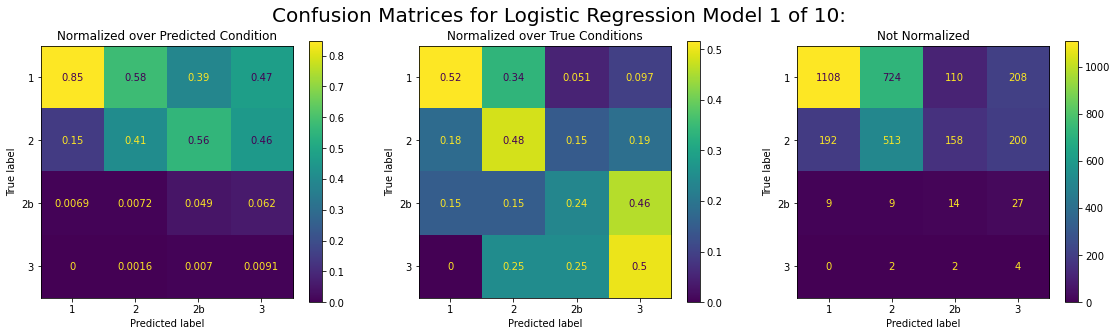

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.844815  0.519070  0.643042      2150
           2   0.408541  0.476952  0.440104      1063
          2b   0.049645  0.237288  0.082111        59
           3   0.011468  0.625000  0.022523         8

    accuracy                       0.500610      3280
   macro avg   0.328617  0.464577  0.296945      3280
weighted avg   0.687089  0.500610  0.565670      3280



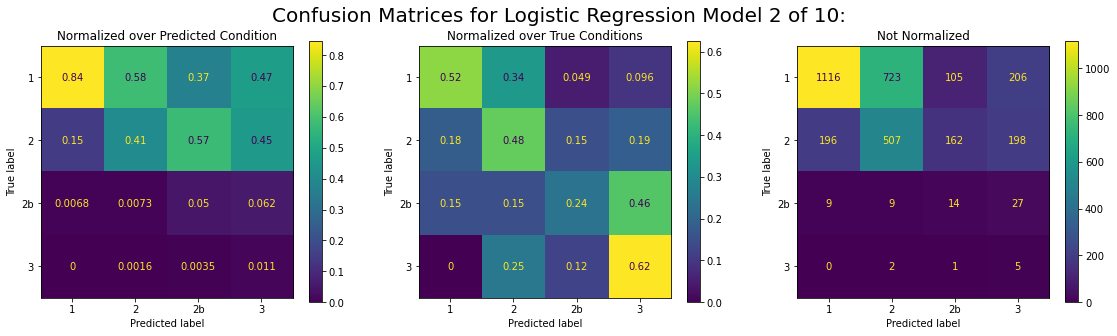

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.851195  0.513488  0.640557      2150
           2   0.410970  0.486359  0.445498      1063
          2b   0.043919  0.220339  0.073239        59
           3   0.009324  0.500000  0.018307         8

    accuracy                       0.499390      3280
   macro avg   0.328852  0.430047  0.294400      3280
weighted avg   0.691950  0.499390  0.565619      3280



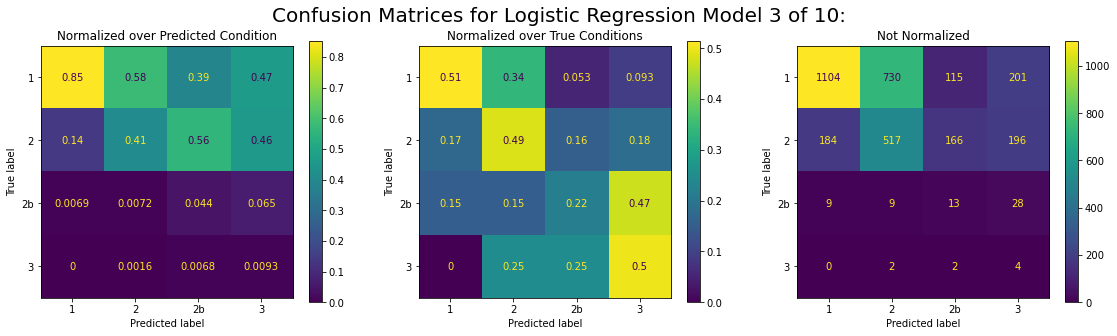

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.847086  0.520465  0.644771      2150
           2   0.414692  0.493885  0.450837      1063
          2b   0.050781  0.220339  0.082540        59
           3   0.009153  0.500000  0.017978         8

    accuracy                       0.506402      3280
   macro avg   0.330428  0.433672  0.299031      3280
weighted avg   0.690586  0.506402  0.570278      3280



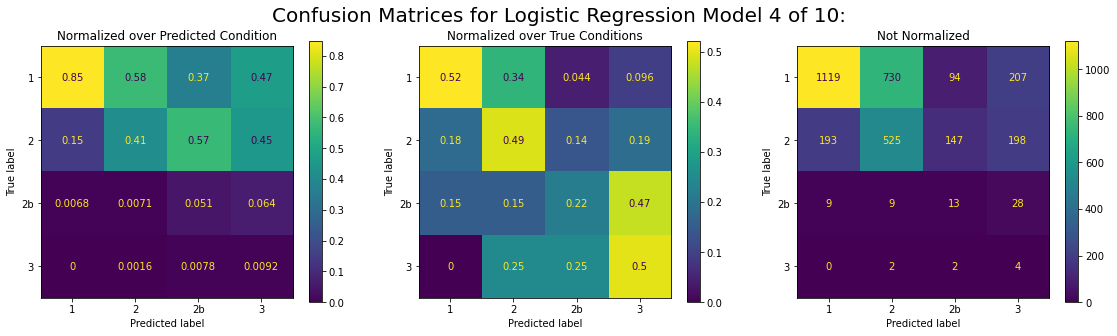

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.839390  0.537209  0.655133      2150
           2   0.414346  0.461900  0.436833      1063
          2b   0.049645  0.237288  0.082111        59
           3   0.011442  0.625000  0.022472         8

    accuracy                       0.507622      3280
   macro avg   0.328706  0.465349  0.299137      3280
weighted avg   0.685414  0.507622  0.572535      3280



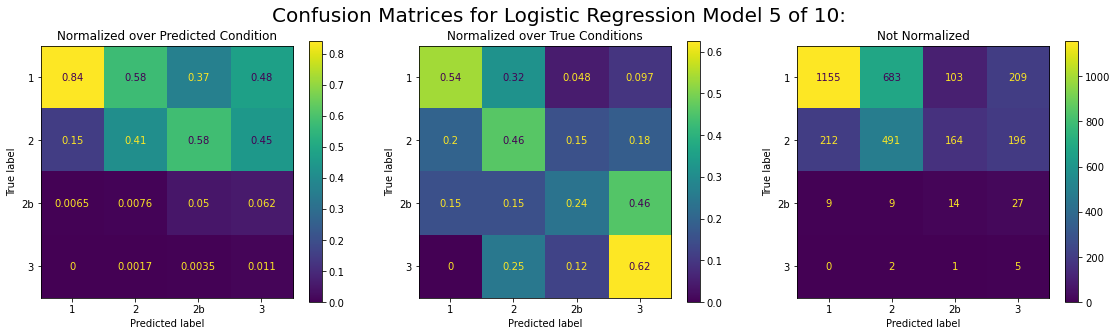

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.848207  0.517209  0.642589      2150
           2   0.413269  0.486359  0.446845      1063
          2b   0.051370  0.254237  0.085470        59
           3   0.009390  0.500000  0.018433         8

    accuracy                       0.502439      3280
   macro avg   0.330559  0.439451  0.298334      3280
weighted avg   0.690871  0.502439  0.567608      3280



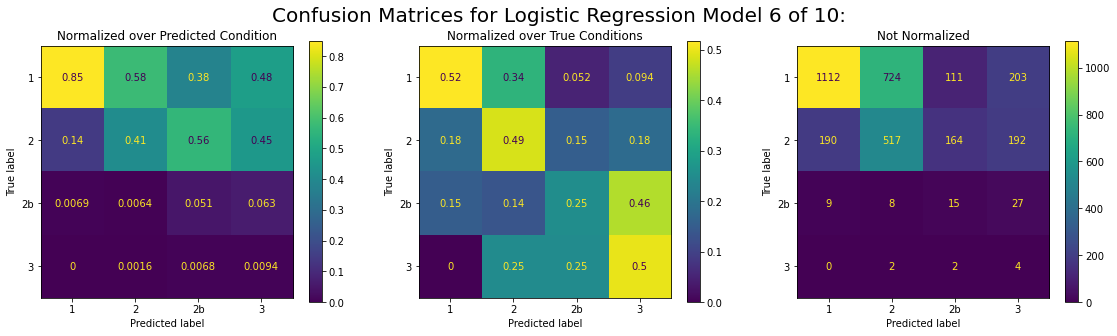

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.847432  0.521860  0.645941      2150
           2   0.416272  0.495767  0.452555      1063
          2b   0.049808  0.220339  0.081250        59
           3   0.009324  0.500000  0.018307         8

    accuracy                       0.507927      3280
   macro avg   0.330709  0.434492  0.299513      3280
weighted avg   0.691308  0.507927  0.571579      3280



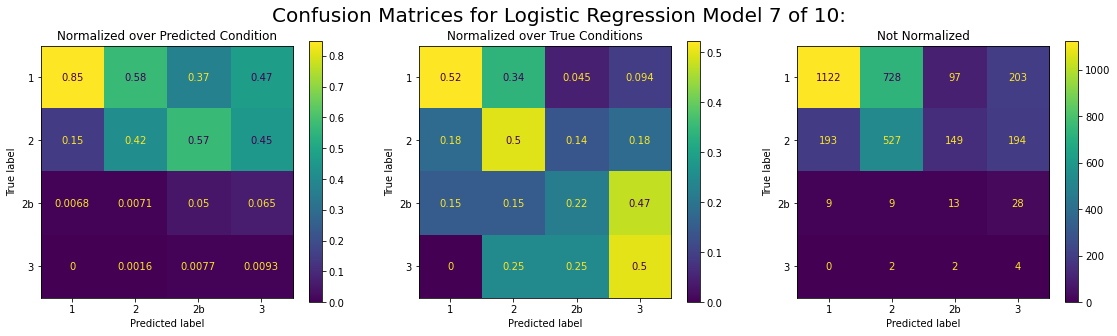

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.846854  0.519535  0.643990      2150
           2   0.415574  0.507056  0.456780      1063
          2b   0.053942  0.220339  0.086667        59
           3   0.009456  0.500000  0.018561         8

    accuracy                       0.510061      3280
   macro avg   0.331457  0.436732  0.301499      3280
weighted avg   0.690777  0.510061  0.571767      3280



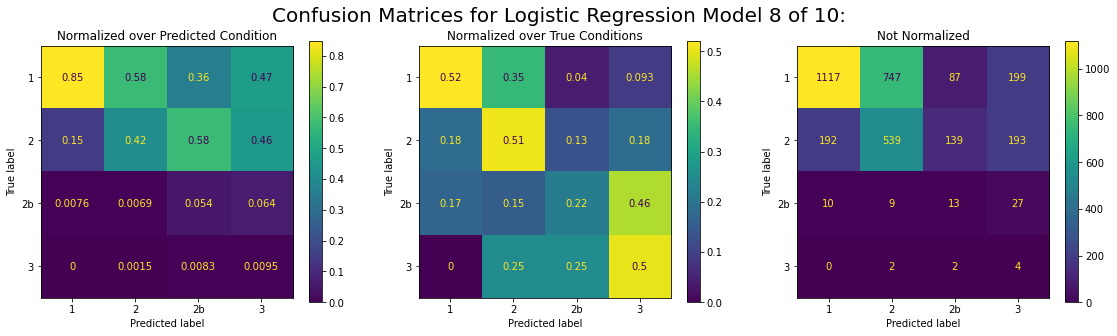

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.848926  0.514884  0.640996      2150
           2   0.409849  0.485419  0.444444      1063
          2b   0.043478  0.203390  0.071642        59
           3   0.009070  0.500000  0.017817         8

    accuracy                       0.499695      3280
   macro avg   0.327831  0.425923  0.293725      3280
weighted avg   0.690091  0.499695  0.565535      3280



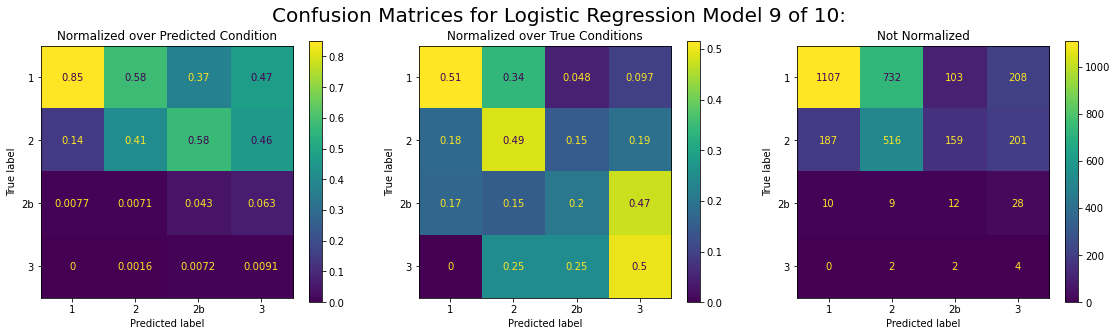

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.852446  0.518605  0.644881      2150
           2   0.413355  0.489182  0.448083      1063
          2b   0.043046  0.220339  0.072022        59
           3   0.009709  0.500000  0.019048         8

    accuracy                       0.503659      3280
   macro avg   0.329639  0.432031  0.296008      3280
weighted avg   0.693528  0.503659  0.569271      3280



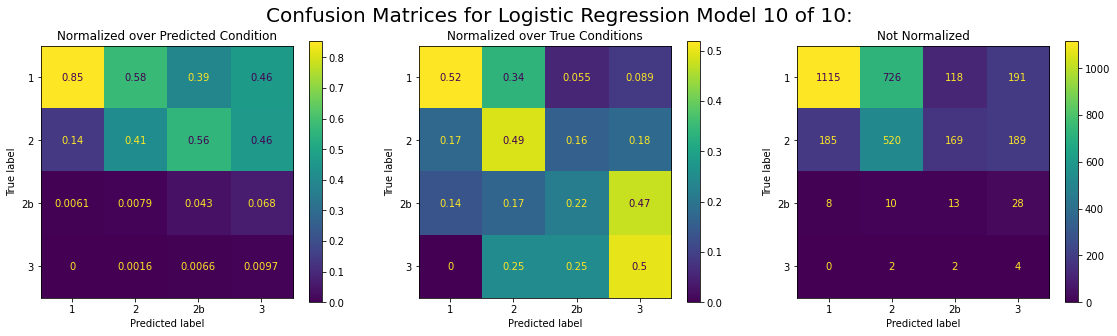

In [66]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    logistic_regression_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [67]:
print_elapsed_time(notebook_start_time)

Elapsed time is 4000.8737372049363 seconds.


In [68]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

fit_time: mean = 1.390619, std = 0.259017
fit_time :[1.4250977  1.66953635 1.95310783 1.6058979  1.20942092 1.21657085
 1.13938522 1.10406828 1.31599545 1.26711082]

score_time: mean = 0.246712, std = 0.088141
score_time :[0.26919031 0.41639805 0.34174609 0.35705566 0.17985654 0.20635128
 0.17566872 0.1746285  0.17126369 0.17495704]

test_f1_macro: mean = 0.474315, std = 0.013292
test_f1_macro :[0.49098022 0.45804141 0.46220561 0.45129795 0.49153523 0.48346694
 0.46593994 0.48016475 0.48115835 0.47835621]

test_f1_weighted: mean = 0.474315, std = 0.013292
test_f1_weighted :[0.49098022 0.45804141 0.46220561 0.45129795 0.49153523 0.48346694
 0.46593994 0.48016475 0.48115835 0.47835621]

test_precision_macro: mean = 0.487582, std = 0.011209
test_precision_macro :[0.4993779  0.47294912 0.47255908 0.46790026 0.50020856 0.49344876
 0.49051342 0.49254038 0.49257304 0.49375182]

test_precision_weighted: mean = 0.487582, std = 0.011209
test_precision_weighted :[0.4993779  0.47294912 0.47255908 

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.847727  0.520465  0.644957      2150
           2   0.415323  0.484478  0.447243      1063
          2b   0.037975  0.152542  0.060811        59
           3   0.010352  0.625000  0.020367         8

    accuracy                       0.502439      3280
   macro avg   0.327844  0.445621  0.293344      3280
weighted avg   0.690983  0.502439  0.568850      3280



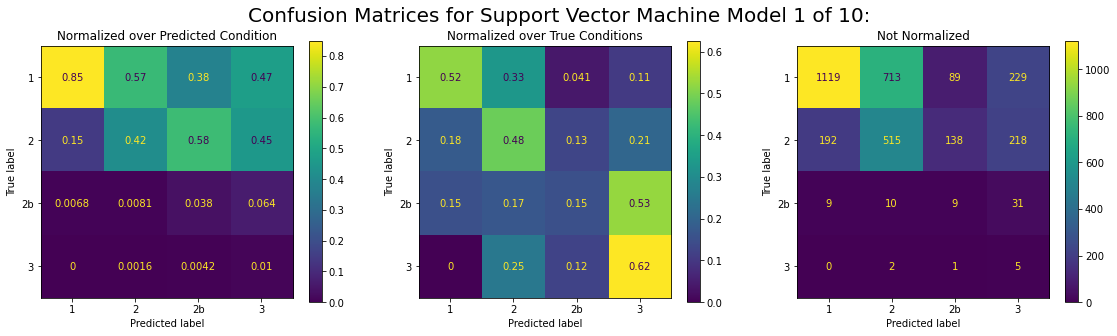

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.858421  0.490698  0.624445      2150
           2   0.409496  0.519285  0.457901      1063
          2b   0.044053  0.169492  0.069930        59
           3   0.010504  0.625000  0.020661         8

    accuracy                       0.494512      3280
   macro avg   0.330619  0.451119  0.293234      3280
weighted avg   0.696214  0.494512  0.559024      3280



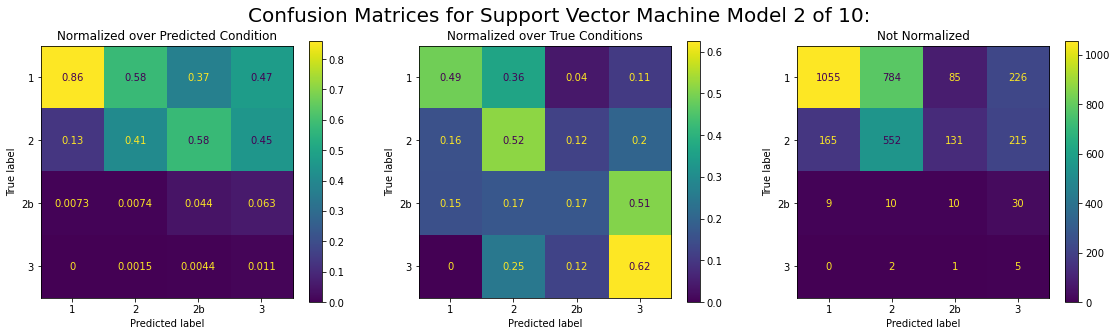

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.851997  0.506047  0.634958      2150
           2   0.410632  0.501411  0.451504      1063
          2b   0.046729  0.169492  0.073260        59
           3   0.010183  0.625000  0.020040         8

    accuracy                       0.498780      3280
   macro avg   0.329885  0.450487  0.294940      3280
weighted avg   0.692419  0.498780  0.563899      3280



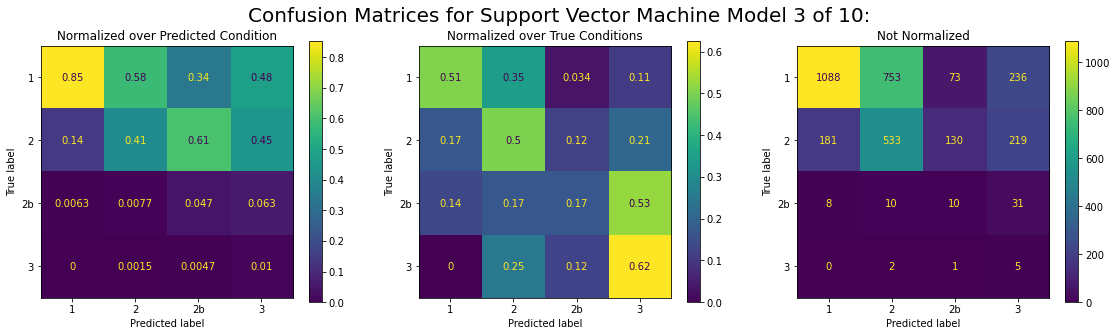

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.850230  0.514884  0.641367      2150
           2   0.417255  0.500470  0.455090      1063
          2b   0.043062  0.152542  0.067164        59
           3   0.010121  0.625000  0.019920         8

    accuracy                       0.503963      3280
   macro avg   0.330167  0.448224  0.295885      3280
weighted avg   0.693341  0.503963  0.569153      3280



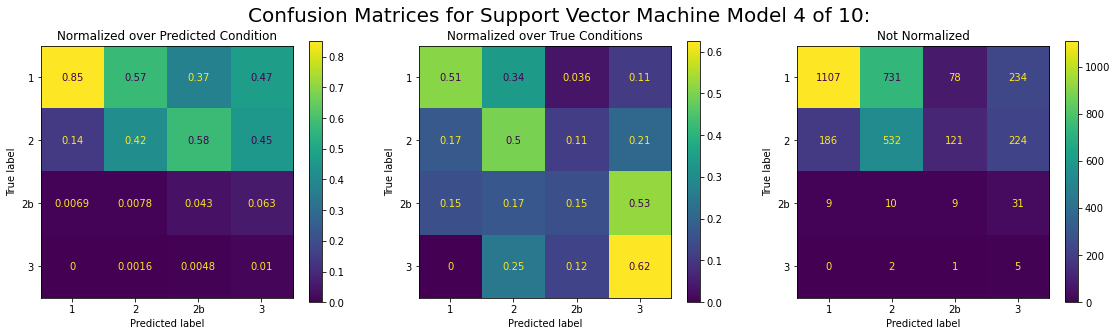

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.850230  0.514884  0.641367      2150
           2   0.411765  0.480715  0.443576      1063
          2b   0.041509  0.186441  0.067901        59
           3   0.010593  0.625000  0.020833         8

    accuracy                       0.498171      3280
   macro avg   0.328524  0.451760  0.293420      3280
weighted avg   0.691535  0.498171  0.565437      3280



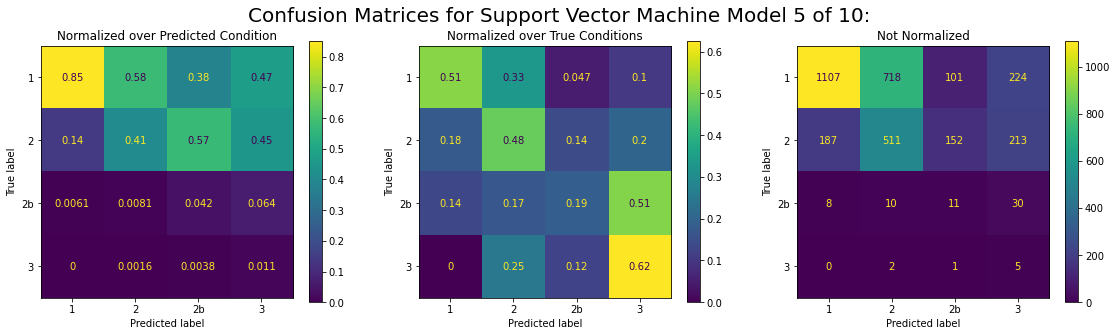

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.847926  0.513488  0.639629      2150
           2   0.413333  0.495767  0.450813      1063
          2b   0.048035  0.186441  0.076389        59
           3   0.010549  0.625000  0.020747         8

    accuracy                       0.502134      3280
   macro avg   0.329961  0.455174  0.296894      3280
weighted avg   0.690650  0.502134  0.566796      3280



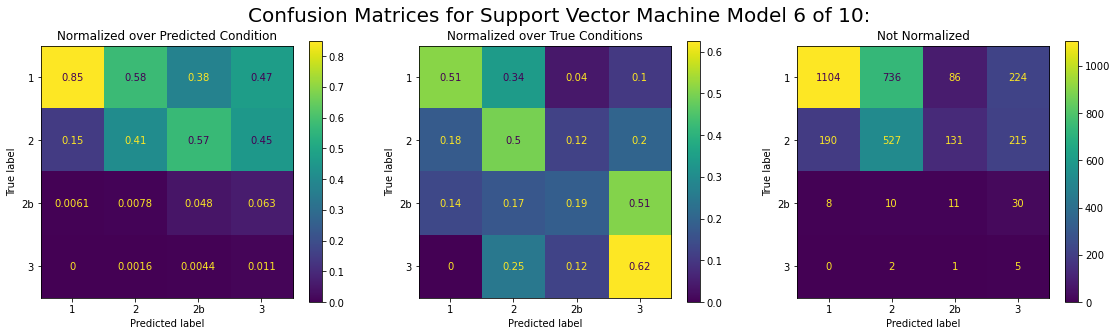

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.848508  0.515814  0.641597      2150
           2   0.415094  0.496707  0.452248      1063
          2b   0.042654  0.152542  0.066667        59
           3   0.010204  0.625000  0.020080         8

    accuracy                       0.503354      3280
   macro avg   0.329115  0.447516  0.295148      3280
weighted avg   0.691505  0.503354  0.568374      3280



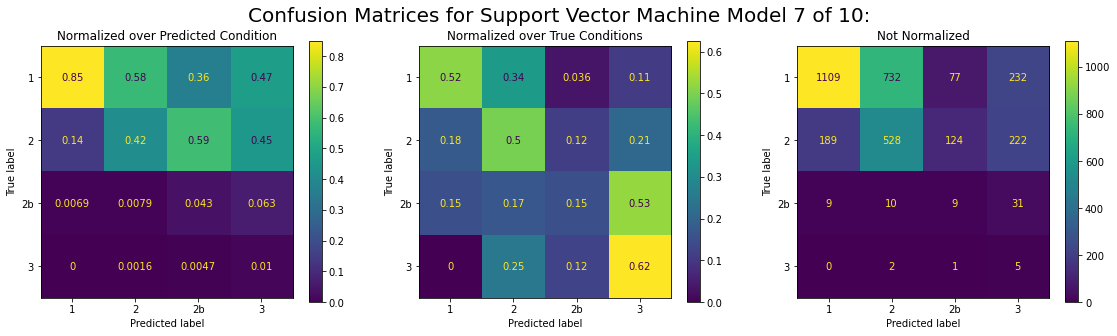

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.849115  0.513023  0.639606      2150
           2   0.412686  0.495767  0.450427      1063
          2b   0.045455  0.169492  0.071685        59
           3   0.010331  0.625000  0.020325         8

    accuracy                       0.501524      3280
   macro avg   0.329396  0.450820  0.295511      3280
weighted avg   0.691173  0.501524  0.566570      3280



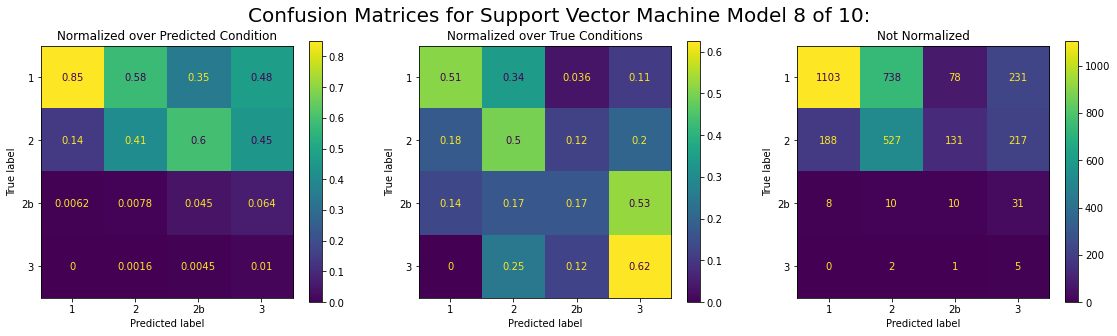

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.848970  0.517674  0.643167      2150
           2   0.412238  0.481656  0.444252      1063
          2b   0.037657  0.152542  0.060403        59
           3   0.010246  0.625000  0.020161         8

    accuracy                       0.499695      3280
   macro avg   0.327278  0.444218  0.291996      3280
weighted avg   0.690792  0.499695  0.566699      3280



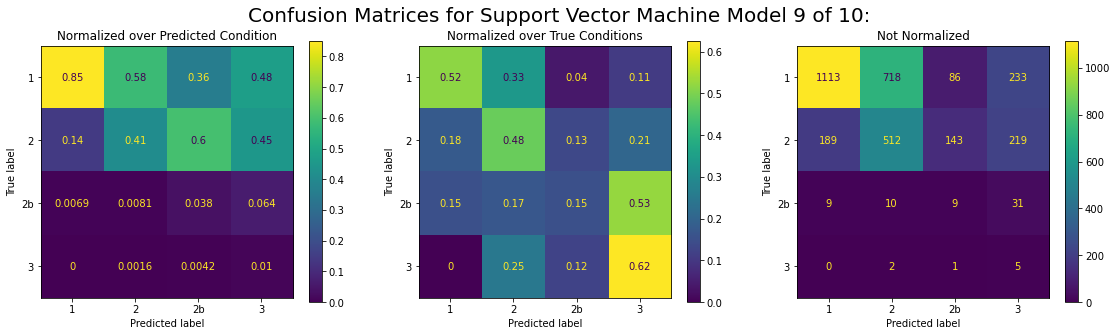

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.848508  0.515814  0.641597      2150
           2   0.412288  0.479774  0.443478      1063
          2b   0.041199  0.186441  0.067485        59
           3   0.010661  0.625000  0.020964         8

    accuracy                       0.498476      3280
   macro avg   0.328164  0.451757  0.293381      3280
weighted avg   0.690570  0.498476  0.565549      3280



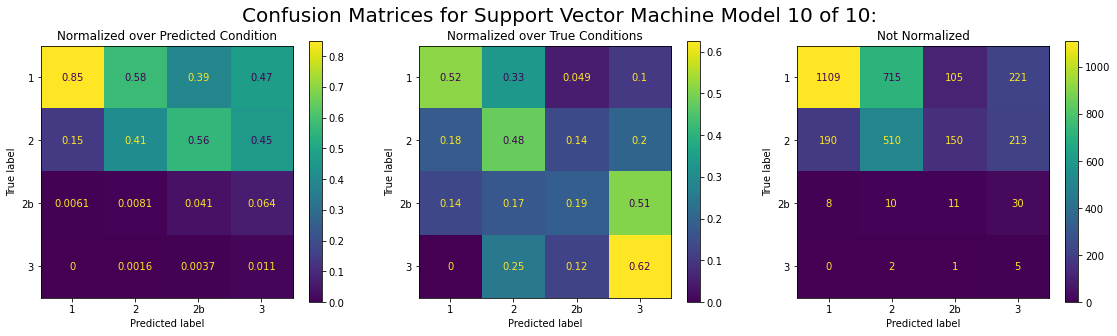

In [69]:
# For each support vector machine classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [70]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

fit_time: mean = 0.121907, std = 0.039371
fit_time :[0.10782266 0.08000946 0.14157867 0.09928179 0.0645597  0.14924121
 0.09456801 0.20144963 0.11951375 0.16104627]

score_time: mean = 15.504985, std = 0.512988
score_time :[15.58265638 15.77253604 16.36124682 15.94197536 14.63705349 14.73411274
 15.92222714 15.5324111  15.34877253 15.2168622 ]

test_f1_macro: mean = 0.532460, std = 0.012024
test_f1_macro :[0.55007267 0.5275016  0.50782836 0.52167124 0.53474251 0.54140941
 0.54791358 0.53131119 0.52565822 0.53649153]

test_f1_weighted: mean = 0.532460, std = 0.012024
test_f1_weighted :[0.55007267 0.5275016  0.50782836 0.52167124 0.53474251 0.54140941
 0.54791358 0.53131119 0.52565822 0.53649153]

test_neg_log_loss: mean = -1.983229, std = 0.150463
test_neg_log_loss :[-1.80749424 -2.08090081 -2.05732657 -2.23078316 -1.78556805 -1.88386047
 -2.0758034  -2.0672052  -2.07505331 -1.76829138]

test_precision_macro: mean = 0.535653, std = 0.013428
test_precision_macro :[0.55350214 0.5300913  0

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.843558  0.511628  0.636943      2150
           2   0.422371  0.476011  0.447590      1063
          2b   0.063660  0.406780  0.110092        59
           3   0.019950  1.000000  0.039120         8

    accuracy                       0.499390      3280
   macro avg   0.337385  0.598605  0.308436      3280
weighted avg   0.691020  0.499390  0.564641      3280



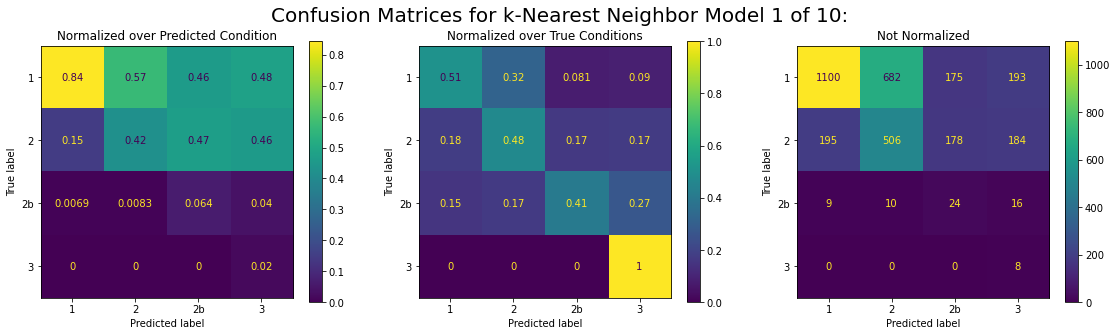

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.830278  0.568837  0.675131      2150
           2   0.440533  0.435560  0.438032      1063
          2b   0.064516  0.372881  0.110000        59
           3   0.019277  1.000000  0.037825         8

    accuracy                       0.523171      3280
   macro avg   0.338651  0.594320  0.315247      3280
weighted avg   0.688215  0.523171  0.586571      3280



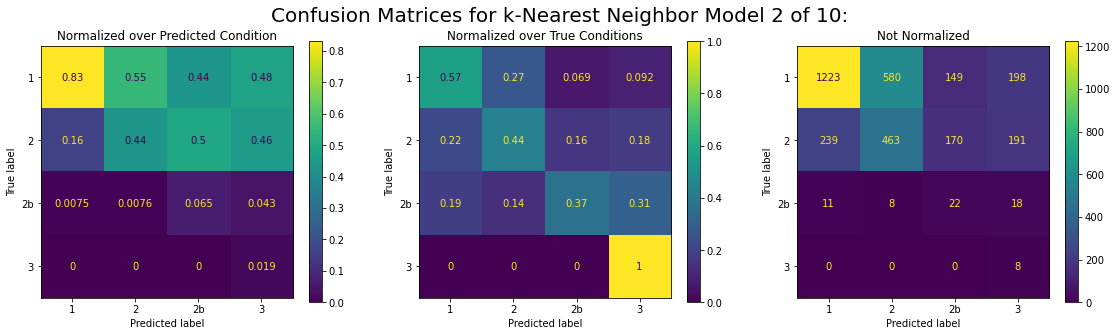

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.825999  0.567442  0.672732      2150
           2   0.432195  0.416745  0.424330      1063
          2b   0.052778  0.322034  0.090692        59
           3   0.019139  1.000000  0.037559         8

    accuracy                       0.515244      3280
   macro avg   0.332528  0.576555  0.306328      3280
weighted avg   0.682496  0.515244  0.580210      3280



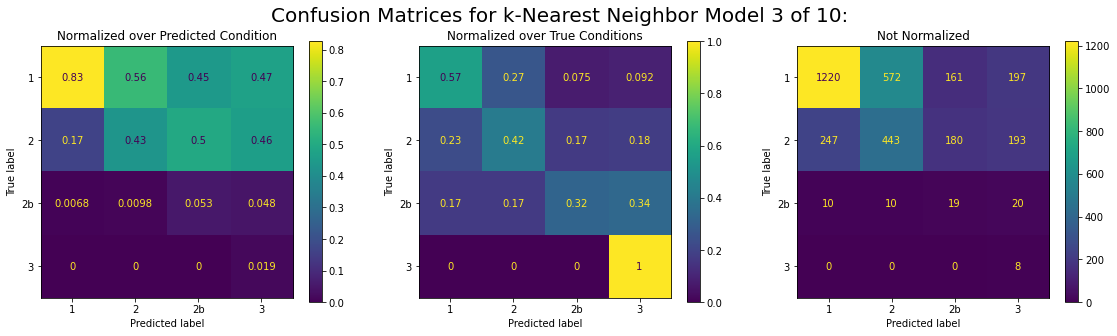

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.836553  0.523721  0.644165      2150
           2   0.418350  0.467545  0.441582      1063
          2b   0.059211  0.305085  0.099174        59
           3   0.018100  1.000000  0.035556         8

    accuracy                       0.502744      3280
   macro avg   0.333053  0.574088  0.305119      3280
weighted avg   0.685041  0.502744  0.567223      3280



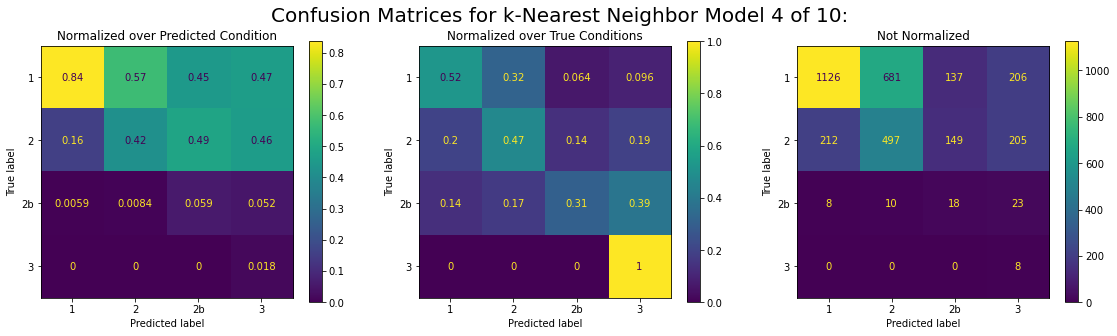

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.822436  0.555814  0.663336      2150
           2   0.429245  0.428034  0.428639      1063
          2b   0.063037  0.372881  0.107843        59
           3   0.019139  1.000000  0.037559         8

    accuracy                       0.512195      3280
   macro avg   0.333464  0.589182  0.309344      3280
weighted avg   0.679390  0.512195  0.575756      3280



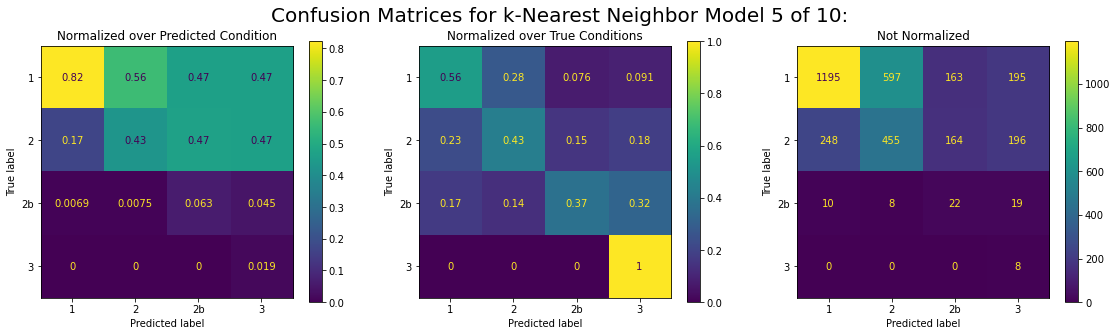

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.830727  0.568372  0.674952      2150
           2   0.439885  0.433678  0.436760      1063
          2b   0.067227  0.406780  0.115385        59
           3   0.019802  1.000000  0.038835         8

    accuracy                       0.522866      3280
   macro avg   0.339410  0.602208  0.316483      3280
weighted avg   0.688350  0.522866  0.586140      3280



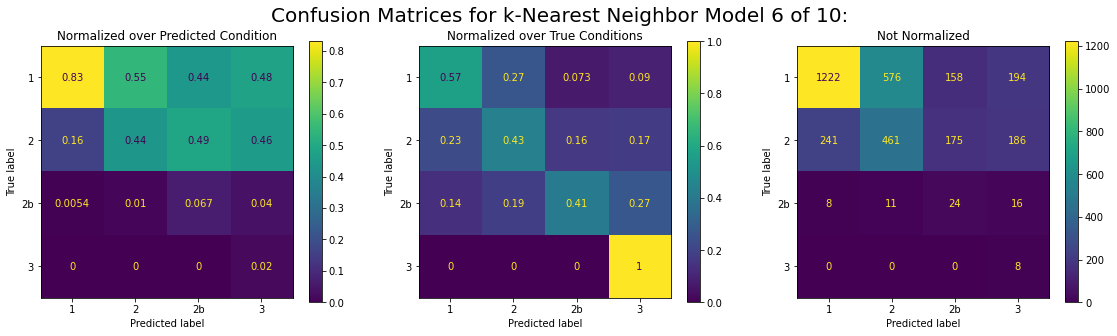

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.844646  0.520930  0.644419      2150
           2   0.422018  0.476011  0.447392      1063
          2b   0.058997  0.338983  0.100503        59
           3   0.019231  1.000000  0.037736         8

    accuracy                       0.504268      3280
   macro avg   0.336223  0.583981  0.307512      3280
weighted avg   0.691533  0.504268  0.569302      3280



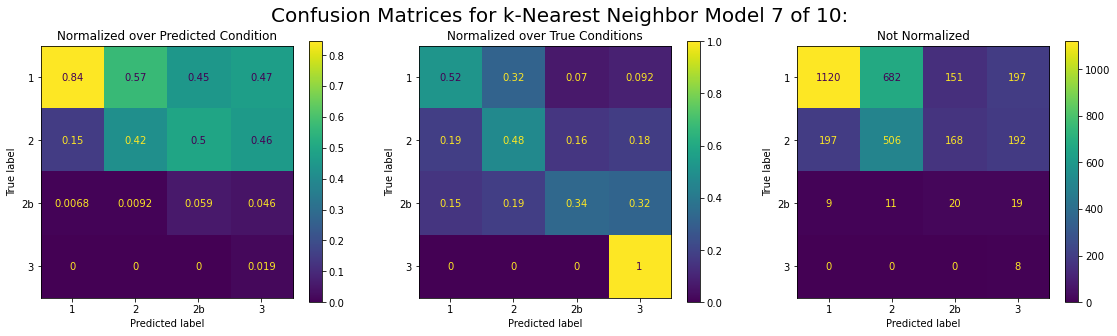

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.829645  0.575349  0.679484      2150
           2   0.443696  0.433678  0.438630      1063
          2b   0.065903  0.389831  0.112745        59
           3   0.019950  1.000000  0.039120         8

    accuracy                       0.527134      3280
   macro avg   0.339798  0.599714  0.317495      3280
weighted avg   0.688851  0.527134  0.589670      3280



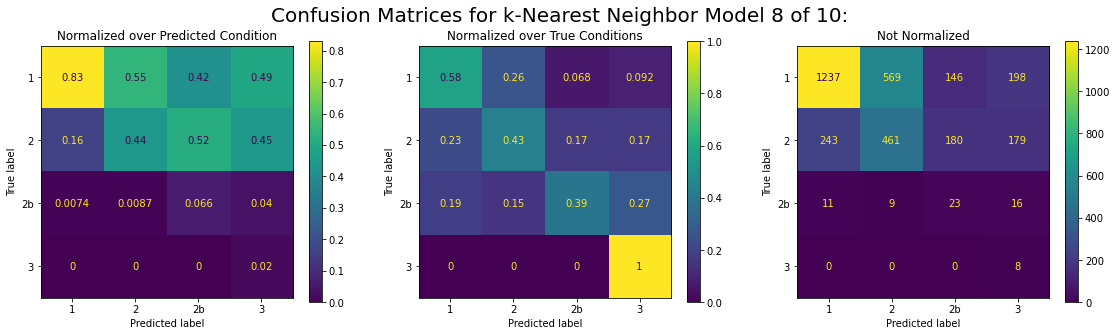

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.828610  0.571163  0.676211      2150
           2   0.446583  0.436500  0.441484      1063
          2b   0.054496  0.338983  0.093897        59
           3   0.020408  1.000000  0.040000         8

    accuracy                       0.524390      3280
   macro avg   0.337524  0.586662  0.312898      3280
weighted avg   0.688905  0.524390  0.588114      3280



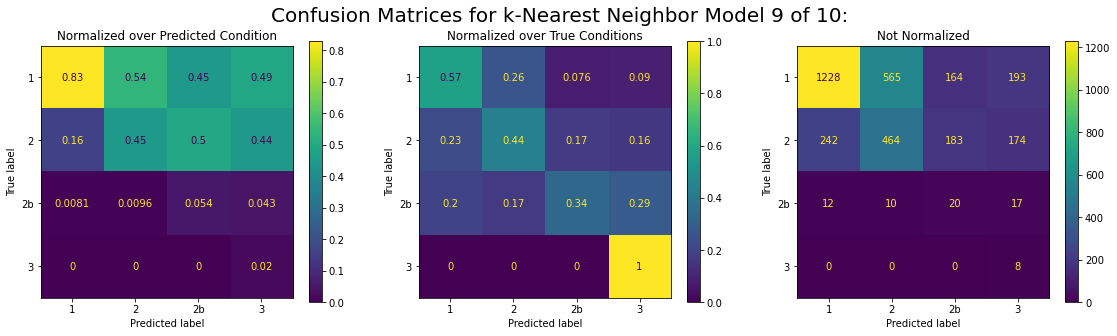

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.844920  0.514419  0.639491      2150
           2   0.422407  0.478833  0.448854      1063
          2b   0.066482  0.406780  0.114286        59
           3   0.019753  1.000000  0.038741         8

    accuracy                       0.502134      3280
   macro avg   0.338390  0.600008  0.310343      3280
weighted avg   0.691974  0.502134  0.566796      3280



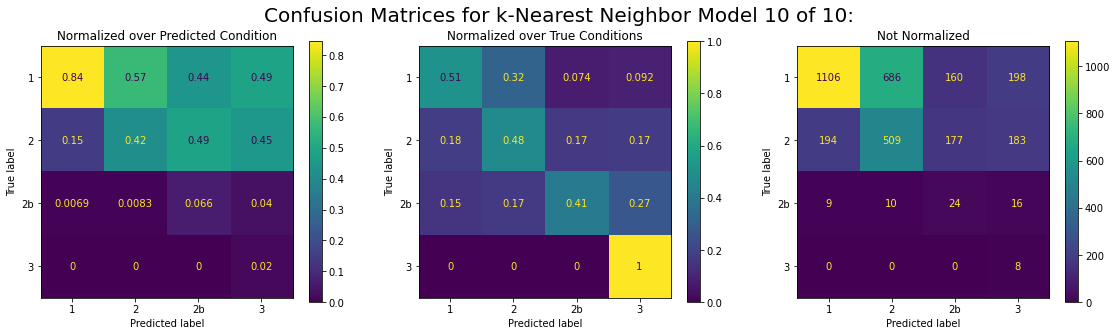

In [71]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    knn_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [72]:
print('Reports and graphics generated in %f seconds' % (elapsed_time(t0)))

Reports and graphics generated in 588.213221 seconds


In [73]:
print_elapsed_time(notebook_start_time)

Elapsed time is 4544.664661246003 seconds.
